In [18]:
#This file is only looking at the roster plots for old organoid data
import networkx as nx
import numpy as np
import pickle
import pandas as pd
from scipy.io import loadmat
import h5py
from scipy.ndimage import gaussian_filter
from scipy.signal import correlate, gaussian
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import itertools
from pathlib import Path
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

result_32 (119966, 168)
result_33 (60000, 168)


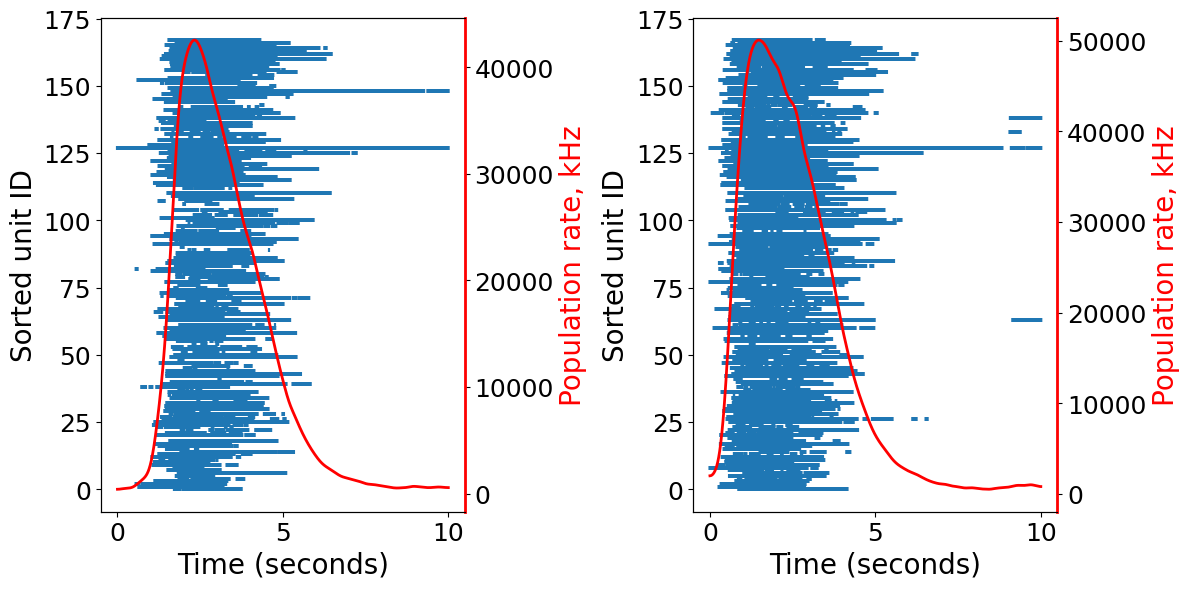

In [28]:
ALL_FILES = [
    "result_32",
    "result_33",
]
# Load your .mat file

"""
# Raster plots for 3 min of recording

# Parameters:
# - spike_times: 2D array-like, where each row represents a time unit and each column a neuron.
# - units: int, total number of time units.
# - unit_duration_ms: int, duration of each time unit in milliseconds.
# - total_minutes: int, total time span in minutes.
# """

fig, axs = plt.subplots((len(ALL_FILES) + 1) // 2, 2, figsize=(12, len(ALL_FILES) * 3))
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, fn in enumerate(ALL_FILES):
    try:
        data = loadmat(f"{fn}.mat")
        t_spk_mat = data['t_spk_mat']
    except:
        data = h5py.File(f"{fn}.mat")
        t_spk_mat = np.array(data['t_spk_mat']).T
    print(fn, t_spk_mat.shape)

    # Plotting the raster plot and average spikes per unit
    # ax = axs[idx // 2, idx % 2]
    ax = axs[idx]
    spike_indices = (t_spk_mat[:10*1000] > 100.0).nonzero()
    ax.scatter(spike_indices[0] / 1000.0, spike_indices[1], marker='|', s=10)
    ax.set_xlabel('Time (seconds)', fontsize=20)
    ax.set_ylabel('Sorted unit ID', fontsize=20)
    # ax.set_title(f"Raster Plot for {fn}")
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)

    avg_spikes = np.sum(t_spk_mat, axis=1)[:10*1000]
    avg_spikes = avg_spikes.astype(float)
    avg_spikes_smooth = gaussian_filter1d(avg_spikes, 100)

    ax2 = ax.twinx()
    xs = np.linspace(0, len(avg_spikes), len(avg_spikes)) / 1000.0
    ax2.plot(xs, avg_spikes_smooth, color='red', linewidth=2)
    ax2.yaxis.label.set_color('red')
    ax2.set_ylabel('Population rate, kHz', fontsize=20)
    ax2.spines['right'].set_color('red')
    ax2.spines['right'].set_linewidth(2)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='both', which='minor', labelsize=16)

plt.tight_layout()
plt.show()


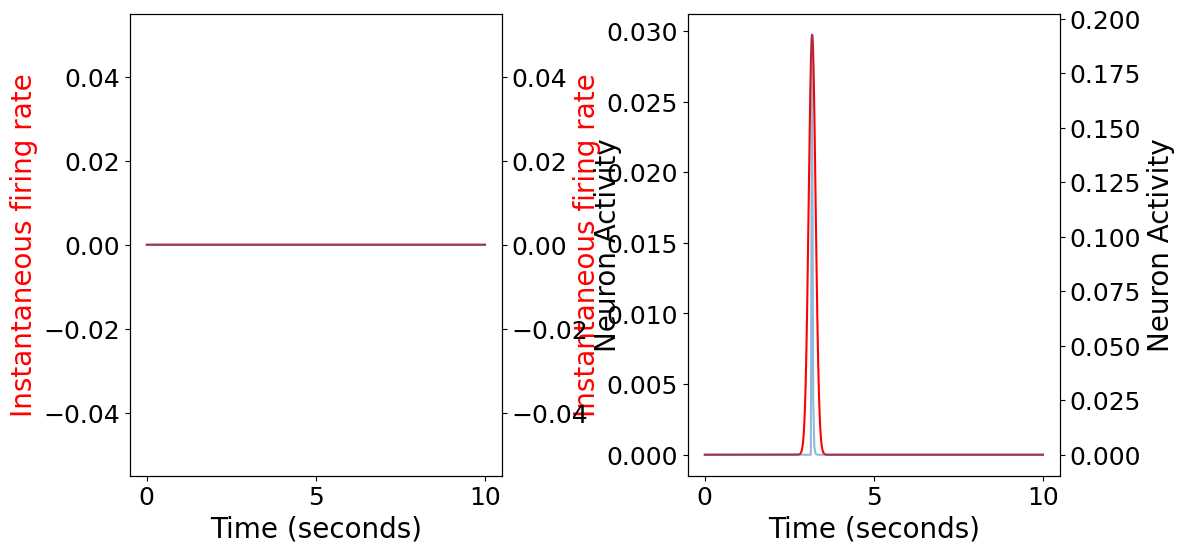

In [24]:
fig, axs = plt.subplots((len(ALL_FILES) + 1) // 2, 2, figsize=(12, len(ALL_FILES) * 3))
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, fn in enumerate(ALL_FILES):
    try:
        data = loadmat(f"{fn}.mat")
        t_spk_mat = data['t_spk_mat']
    except:
        data = h5py.File(f"{fn}.mat")
        t_spk_mat = np.array(data['t_spk_mat']).T
    
    # if fn != "2950_spike_mat_or_rand":
    #     continue

    neuron = t_spk_mat[:, 0].astype(np.float32)
    spike_indices = neuron[:10*1000]
    xs = np.linspace(0, len(spike_indices), len(spike_indices)) / 1000.0
    spike_indices_gaussian = gaussian_filter1d(spike_indices, 100)


    # ax = axs[idx // 2, idx % 2]
    ax = axs[idx]
    ax.plot(xs, spike_indices_gaussian, label='Gaussian', color='red')
    ax.set_xlabel('Time (seconds)', fontsize=20)
    ax.set_ylabel('Instantaneous firing rate', color='red', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    # ax.set_title(f"Raster Plot for {fn}")
    ax2 = ax.twinx()
    ax2.plot(xs, spike_indices, label='Original', alpha=0.5)
    ax2.set_ylabel('Neuron Activity', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='both', which='minor', labelsize=16)
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


    
    
  
    # plt.plot(xs, spike_indices)
    #.nonzero()
    # print(spike_indices)
    # plt.scatter(spike_indices[0] / 1000.0, spike_indices[1], marker='|', s=10)
    # plt.set_xlabel('Time (seconds)')
    # ax.set_ylabel('Sorted unit ID')
    # ax.set_title(f"Raster Plot for {fn}")
   
        

    
    

 



   



1. (no window) In order to choose threshold for the correlations, we need to make a histogram for each of the organoids data sets
ALL_FILES = [
    "2950_spike_mat_or_rand", #26
    "2953_spike_mat_or_rand", #Tal paper
    "2957_spike_mat_or_rand",
    "5116_spike_mat_or_rand",
]

We want to keep the tail representing the highest correlations

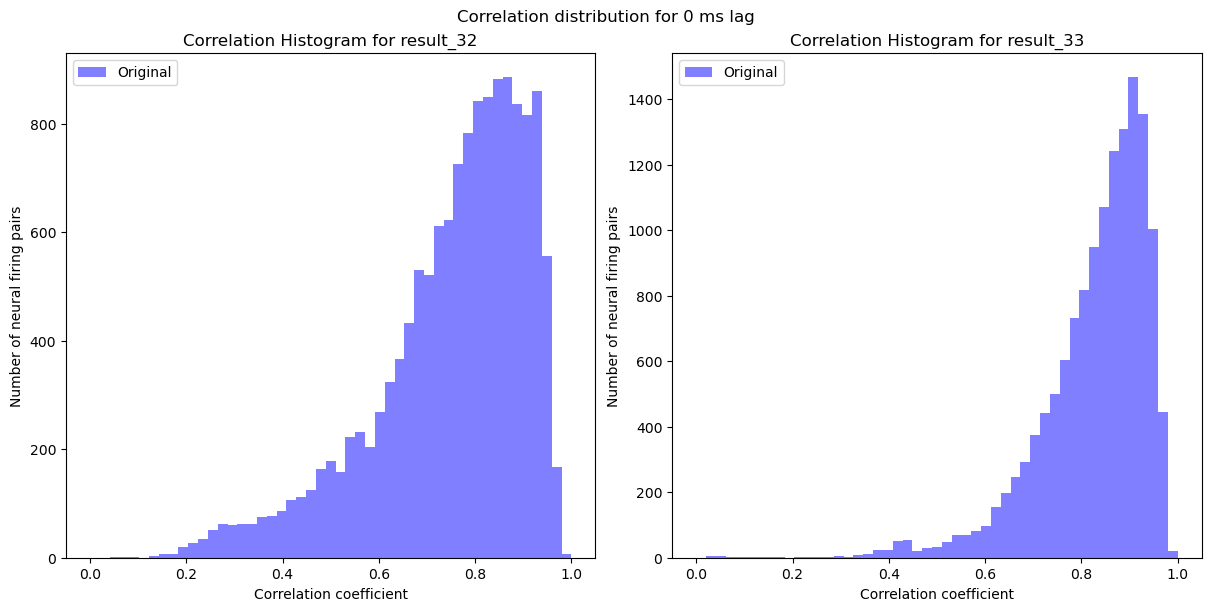

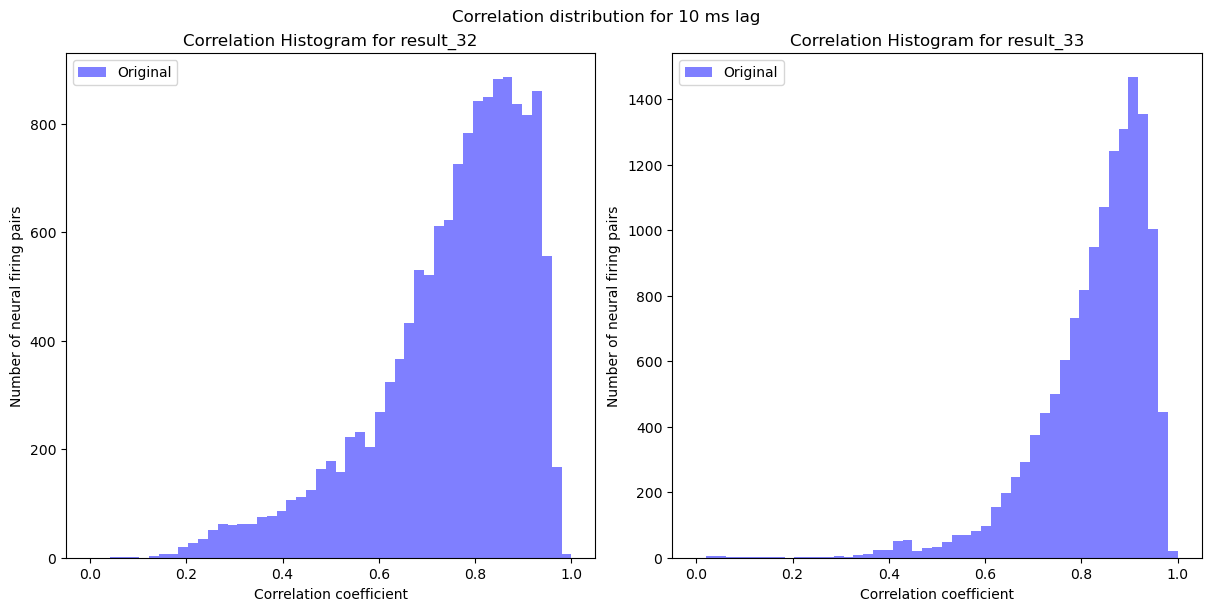

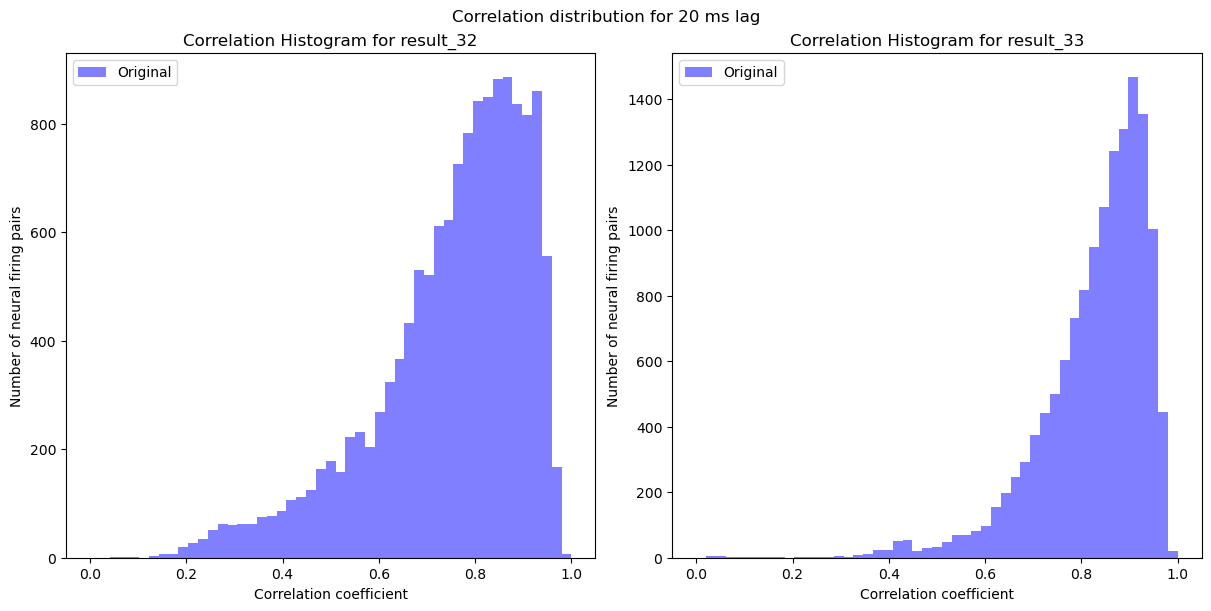

In [29]:
import pickle
from scipy.stats import powerlaw
from scipy.optimize import curve_fit

for lag in [0, 10, 20]:
    fig, axs = plt.subplots((len(ALL_FILES) + 1) // 2, 2, figsize=(12, len(ALL_FILES) * 3), constrained_layout=True)
    fig.suptitle(f"Correlation distribution for {lag} ms lag")

    for idx, fn in enumerate(ALL_FILES):
        with open(f"processed/{fn}_lag_window_0.pkl", "rb") as f:
            data = pickle.load(f)
            data_all = data["all"]
        ax = axs[idx]
        
        idx = np.triu_indices(data_all["corr"].shape[0], 1)
        mask = data_all["corr"][idx]> 0.03
        data_masked = data_all["corr"][idx][mask]
        bins = np.linspace(0, 1, 50)

        hist, _, _ = ax.hist(data_masked, bins=bins, alpha=0.5, label="Original", color='blue')

        ax.set_xlabel("Correlation coefficient")  # Add x-axis title
        ax.set_ylabel("Number of neural firing pairs")  # Add x-axis title
        ax.set_title(f"Correlation Histogram for {fn}")  # Add title with fn
        ax.legend()
    plt.show()
    


In [17]:
# #trying to do log normal
# ALL_FILES = [
#     "2950_spike_mat_or_rand", #26
#     "2953_spike_mat_or_rand", #Tal paper
#     "2957_spike_mat_or_rand",
#     "5116_spike_mat_or_rand",
# ]

# import numpy as np
# import scipy.stats
# import matplotlib.pyplot as plt

# for idx, fn in enumerate(ALL_FILES):
#         with open(f"processed/{fn}_lag_window_0.pkl", "rb") as f:
#             data = pickle.load(f)
#         with open(f"processed/{fn}_lag_window_0_shuffle.pkl", "rb") as f:
#             data_shuffled = pickle.load(f)

#         # Extracting the upper triangle indices
#         idx = np.triu_indices(data["corr"].shape[0], 1)

#         # Applying mask
#         mask = data["corr"][idx] > 0.03
#         data_masked = data["corr"][idx][mask]
#         # Generate log-normal distributed set of sample

#         # Make a fit to the samples.
#         shape, loc, scale = scipy.stats.lognorm.fit(data_masked, floc=0)

#         # Create the histogram plot using matplotlib.  The first two values in
#         # the tuple returned by hist are the number of samples in each bin and
#         # the values of the histogram's bin edges.  counts has length num_bins,
#         # and edges has length num_bins + 1.
#         num_bins = 50
#         clr = '#FFE090'
#         counts, edges, patches = plt.hist(data_masked, bins=num_bins, color=clr, ec='k', label='data_masked')

#         # Create an array of length num_bins containing the center of each bin.
#         centers = 0.5*(edges[:-1] + edges[1:])

#         # Compute the CDF at the edges. Then prob, the array of differences,
#         # is the probability of a sample being in the corresponding bin.
#         cdf = scipy.stats.lognorm.cdf(edges, shape, loc=loc, scale=scale)
#         prob = np.diff(cdf)

#         plt.plot(centers, data_masked.size*prob, 'k-', linewidth=2, label='Expected histogram')

#         # prob can also be approximated using the PDF at the centers multiplied
#         # by the width of the bin:
#         # p = scipy.stats.lognorm.pdf(centers, shape, loc=loc, scale=scale)
#         # prob = p*(edges[1] - edges[0])
#         # plt.plot(centers, samples.size*prob, 'r')

#         plt.legend()


# plt.show()

In [16]:
# #trying to do log normal
# ALL_FILES = [
#     "2950_spike_mat_or_rand", #26
#     "2953_spike_mat_or_rand", #Tal paper
#     "2957_spike_mat_or_rand",
#     "5116_spike_mat_or_rand",
# ]

# import numpy as np
# import scipy.stats
# import matplotlib.pyplot as plt

# for idx, fn in enumerate(ALL_FILES):
#         with open(f"processed/{fn}_lag_window_0.pkl", "rb") as f:
#             data = pickle.load(f)
#         with open(f"processed/{fn}_lag_window_0_shuffle.pkl", "rb") as f:
#             data_shuffled = pickle.load(f)

#         # Extracting the upper triangle indices
#         idx = np.triu_indices(data["corr"].shape[0], 1)

#         # Applying mask
#         mask = data["corr"][idx] > 0.03
#         data_masked = data["corr"][idx][mask]
#         # Generate log-normal distributed set of sample

#         # Make a fit to the samples.
#         shape, loc, scale = scipy.stats.lognorm.fit(data_masked, floc=0)

#         # Create the histogram plot using matplotlib.  The first two values in
#         # the tuple returned by hist are the number of samples in each bin and
#         # the values of the histogram's bin edges.  counts has length num_bins,
#         # and edges has length num_bins + 1.
#         num_bins = 50
#         clr = '#FFE090'
#         counts, edges, patches = plt.hist(data_masked, bins=num_bins, color=clr, ec='k', label='data_masked')

#         # Create an array of length num_bins containing the center of each bin.
#         centers = 0.5*(edges[:-1] + edges[1:])

#         # Compute the CDF at the edges. Then prob, the array of differences,
#         # is the probability of a sample being in the corresponding bin.
#         cdf = scipy.stats.lognorm.cdf(edges, shape, loc=loc, scale=scale)
#         prob = np.diff(cdf)

#         plt.plot(centers, data_masked.size*prob, 'k-', linewidth=2, label='Expected histogram')

#         # prob can also be approximated using the PDF at the centers multiplied
#         # by the width of the bin:
#         # p = scipy.stats.lognorm.pdf(centers, shape, loc=loc, scale=scale)
#         # prob = p*(edges[1] - edges[0])
#         # plt.plot(centers, samples.size*prob, 'r')

#         plt.legend()


# plt.show()

2. (no window)Take the highest correlations tail from step 1. and construct a network 

- node are neural firing rates (one node is 1-2-1 firing rate): one row of the initial matrix
- edge are correlation coefficients 

Result will be four networks for each of highest correlated tail in the given data sets

3. (no window) Perform hole analyzis for the network from Step 2. 

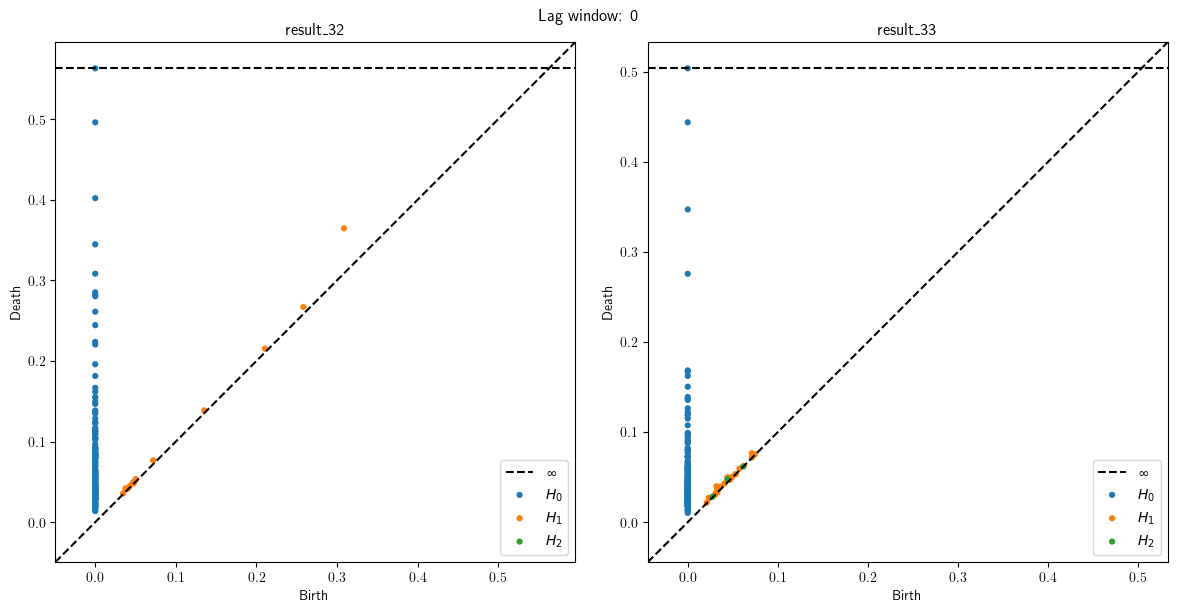

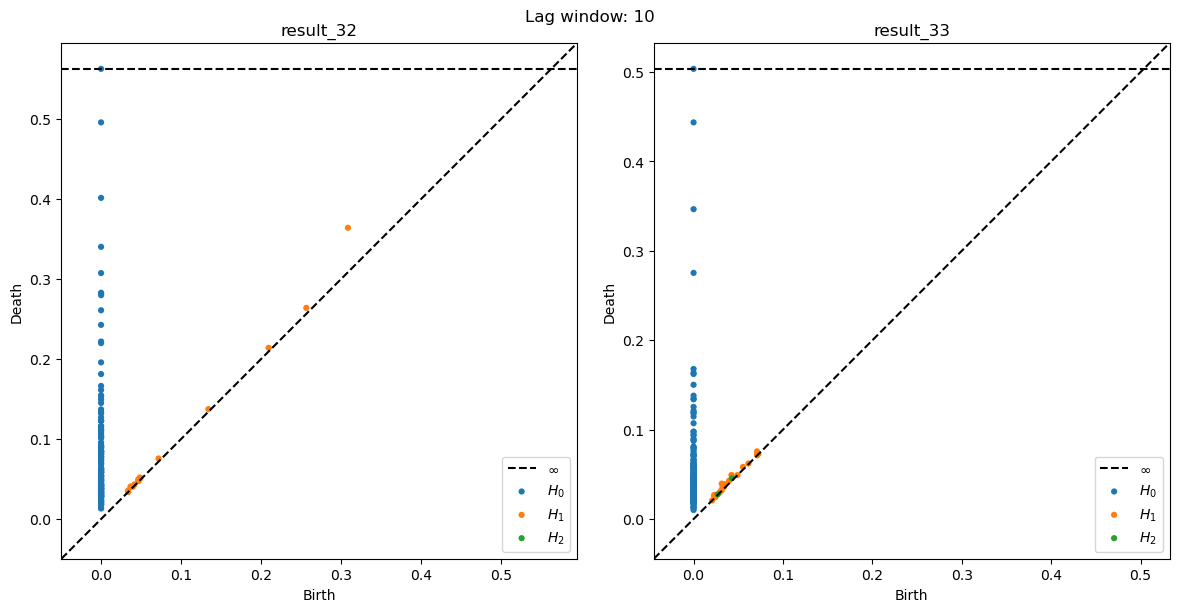

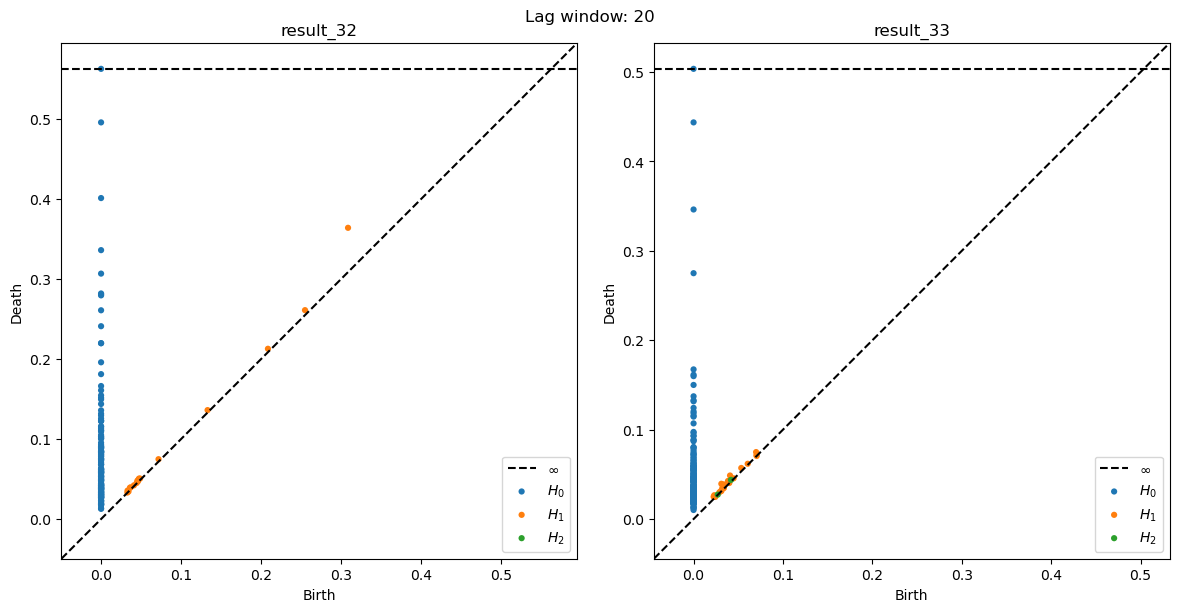

In [30]:
from ripser import ripser
from persim import plot_diagrams

for lag in [0, 10, 20]:
    fig, axs = plt.subplots((len(ALL_FILES) + 1) // 2, 2, figsize=(12, len(ALL_FILES) * 3))
    fig.suptitle(f"Lag window: {lag}")
    for idx, fn in enumerate(ALL_FILES):
        with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
            data = pickle.load(f)
            data = data["all"]
        # plot_diagrams(data["ripser"]["dgms"], ax=axs[idx // 2, idx % 2], show=False, title=f"{fn}")
        plot_diagrams(data["ripser"]["dgms"], ax=axs[idx], show=False, title=f"{fn}")
    fig.tight_layout()
    plt.show()

3. Repeat step 1 and step 2 and step 3 for lag window 10 ms

In [ ]:

for lag in [0, 10, 20]:
    fig, axs = plt.subplots(len(ALL_FILES) // 2, 2, figsize=(12, len(ALL_FILES) * 3))
    fig.suptitle(f"Lag window: {lag}")
    for idx, fn in enumerate(ALL_FILES):
        with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
            data = pickle.load(f)
            data_all = data["all"]
        with open(f"processed/{fn}_lag_window_{lag}_shuffle.pkl", "rb") as f:
            data_shuffled = pickle.load(f)
            data_shuffled_all = data_shuffled["all"]
        ax = axs[idx // 2, idx % 2]
        ax.plot([len(h) for h in data_all["holes"]], label="Original")
        ax.plot([len(h) for h in data_shuffled_all["holes"]], label="Shuffled")
        ax.set_title(f"Number of holes for {fn}")
        ax.legend()
        ax.set_xlabel("Number of nodes")
        ax.set_ylabel("Number of holes")

        data_slices = []
        for slice in data["slices"]:
            data_slices.append([len(h) for h in slice["holes"]])
        
    fig.tight_layout()
    plt.show()

In [ ]:
from scipy.stats import gaussian_kde

for n in [4, 5, 6]:
    for lag in [0, 10, 20]:
        fig, axs = plt.subplots(len(ALL_FILES), 2, figsize=(12, len(ALL_FILES) * 6))
        fig.suptitle(f"Lag window: {lag}, hole size: {n}")
        for idx, fn in enumerate(ALL_FILES):
            for shuffle in [False, True]:
                with open(f"processed/{fn}_lag_window_{lag}{'_shuffle' if shuffle else ''}.pkl", "rb") as f:
                    data = pickle.load(f)
                    data = data["all"]
                ax = axs[idx, int(shuffle)]
                if n >= len(data["holes"]):
                    continue
                xs1, ys1 = zip(*data["holes"][n]) if data["holes"][n] else ([], [])
                xy1 = np.vstack([xs1, ys1])
                # print('here', xy1.shape)
                # log_z1 = np.log(gaussian_kde(xy1)(xy1))
                scatter = ax.scatter(xs1, ys1, s=0.01, alpha=0.1, vmax=10.0)
                ax.set_xlabel("Birth correlation coefficient")
                ax.set_ylabel("Death correlation coefficient")
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.set_title(f"{fn}{', shuffled' if shuffle else ''}")
            
        fig.tight_layout()
        plt.show()

4. Repeat step 1 and step 2 and step 3for lag window 20 ms

In [ ]:

for lag in [0, 10, 20]:
    fig, axs = plt.subplots(len(ALL_FILES) // 2, 2, figsize=(12, len(ALL_FILES) * 3))
    fig.suptitle(f"Lag window: {lag}")
    for idx, fn in enumerate(ALL_FILES):
        with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
            data = pickle.load(f)
            data = data["all"]
        with open(f"processed/{fn}_lag_window_{lag}_shuffle.pkl", "rb") as f:
            data_shuffled = pickle.load(f)
            data_shuffled = data_shuffled["all"]
        ax = axs[idx // 2, idx % 2]
        ax.plot(data["cc_counts"], label="Original")
        ax.plot(data_shuffled["cc_counts"], label="Shuffled")
        ax.set_title(f"Number of connected components for {fn}")
        ax.legend()
        ax.set_xlabel("Number of nodes")
        ax.set_ylabel("Number of connected components")
    fig.tight_layout()
    plt.show()

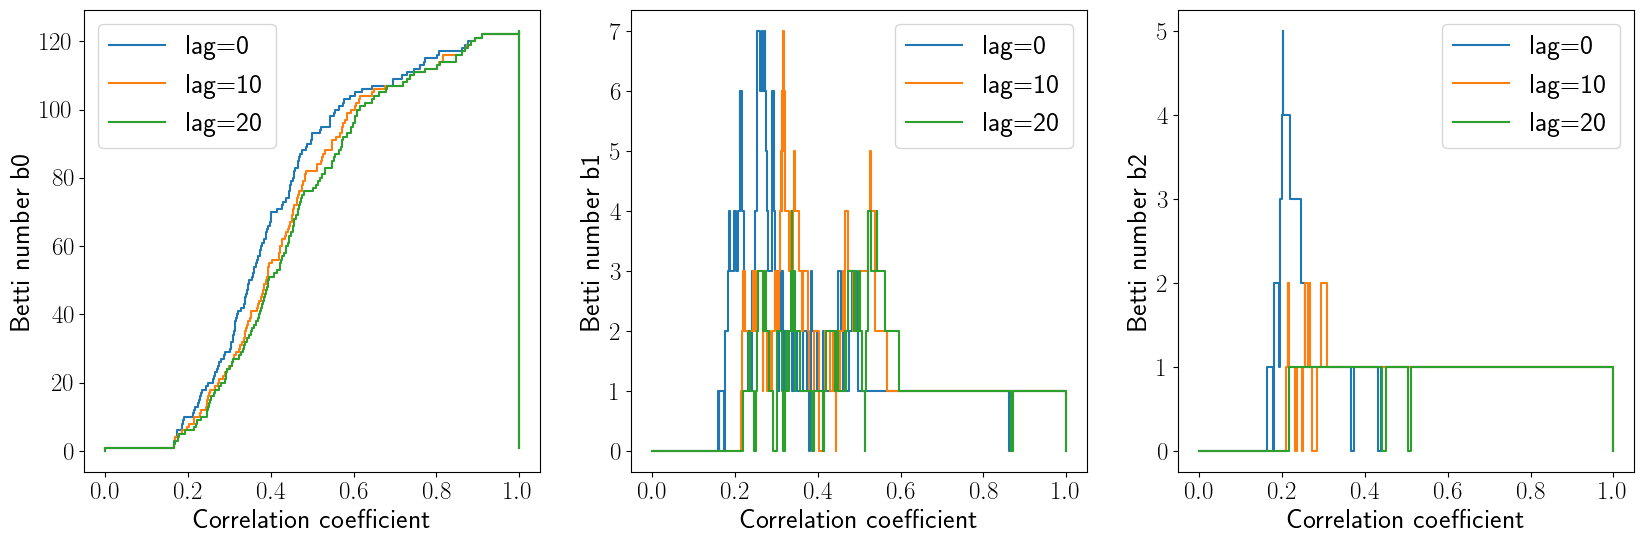

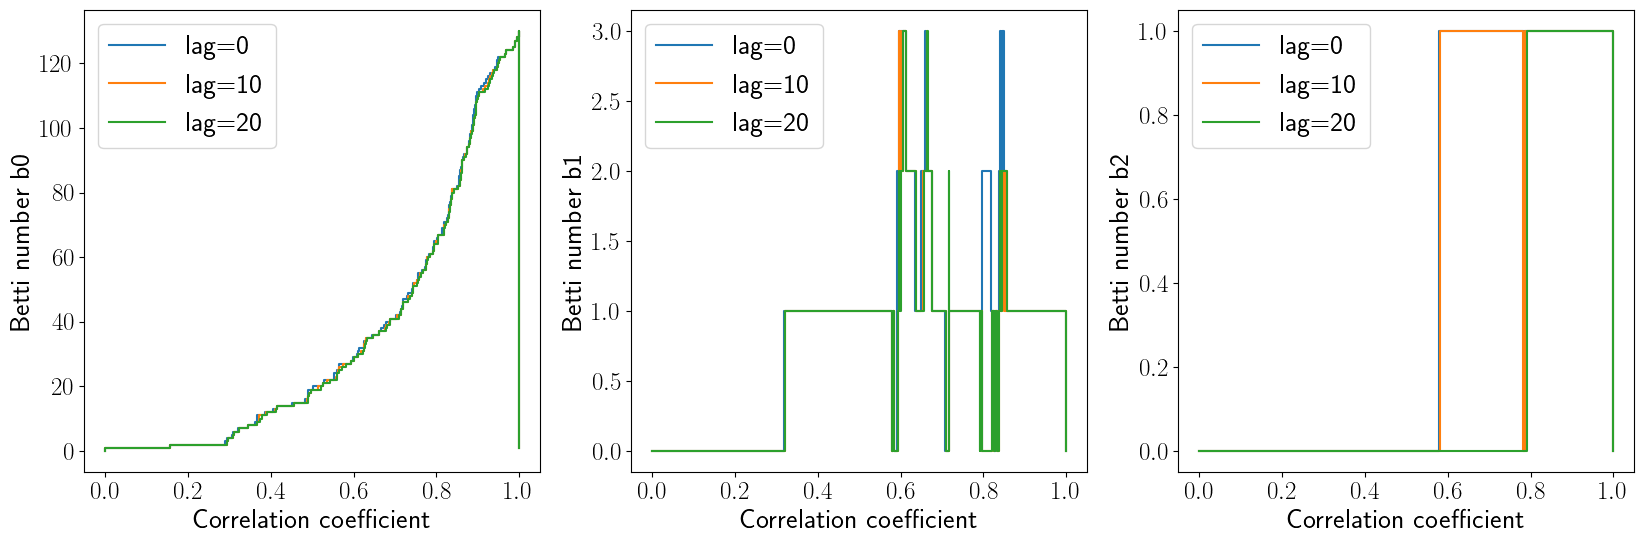

In [17]:
from ripser import ripser
from persim import plot_diagrams

FILES = [
    "5116_spike_mat_or_rand",
    "UCSC_mouse_Pasca_23179",
]
# FILES = ALL_FILES

def compute_live(dgm):
    events = [(0.0, 0), (1.0, 0)]
    if len(dgm) == 0:
        return np.array([]), np.array([])
    for birth, death in dgm:
        events.append((birth, 1))
        events.append((death, -1))
    events.sort()
    t, val = map(np.array, zip(*events))
    val = np.cumsum(val)
    return t, val

for idx, fn in enumerate(FILES):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    for lag in [0, 10, 20]:
        with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
            data = pickle.load(f)
            data = data["all"]
        for it in range(3):
            ax = axs[it]
            t, live_cnt = compute_live(data["ripser"]["dgms"][it])
            t = 1.0 - t
            ax.step(t, live_cnt, label=f"lag={lag}")
            # ax.set_title(f"{fn}, H{it}")
            ax.set_xlabel("Correlation coefficient", fontsize=20)
            ax.set_ylabel(f"Betti number b{it}", fontsize=20)
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.tick_params(axis='both', which='minor', labelsize=16)
            ax.legend(fontsize=20)
    # fig.tight_layout()
    plt.show()

In [22]:

for idx, fn in enumerate(FILES):
    print("Lag\t", end="\t")
    for lag in [0, 10, 20]:
        print(lag, end="\t")
    print()
    for r_min, r_max in [(0.5, 0.7), (0.7, 0.9), (0.9, 1.0)]:
        print(f"({r_min}, {r_max})", end="\t")
        for lag in [0, 10, 20]:
            with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
                data = pickle.load(f)
                data = data["all"]
            cnt = np.sum((data["corr"] > r_min) & (data["corr"] <= r_max))
            print(cnt, end="\t")
        print()
        
        

5116_spike_mat_or_rand
Lag		0	10	20	
(0.5, 0.7)	1546	1832	1978	
(0.7, 0.9)	218	260	326	
(0.9, 1.0)	93	147	151	
M2S2_t_spk_mat_sorted
Lag		0	10	20	
(0.5, 0.7)	25926	27062	27900	
(0.7, 0.9)	5044	5478	5768	
(0.9, 1.0)	89	460	439	


5116_spike_mat_or_rand
Lag		0	10	20	
(0.5, 0.7)	34	29	25	
(0.7, 0.9)	86	81	78	
(0.9, 1.0)	114	112	112	


/tmp/ipykernel_478071/836624664.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


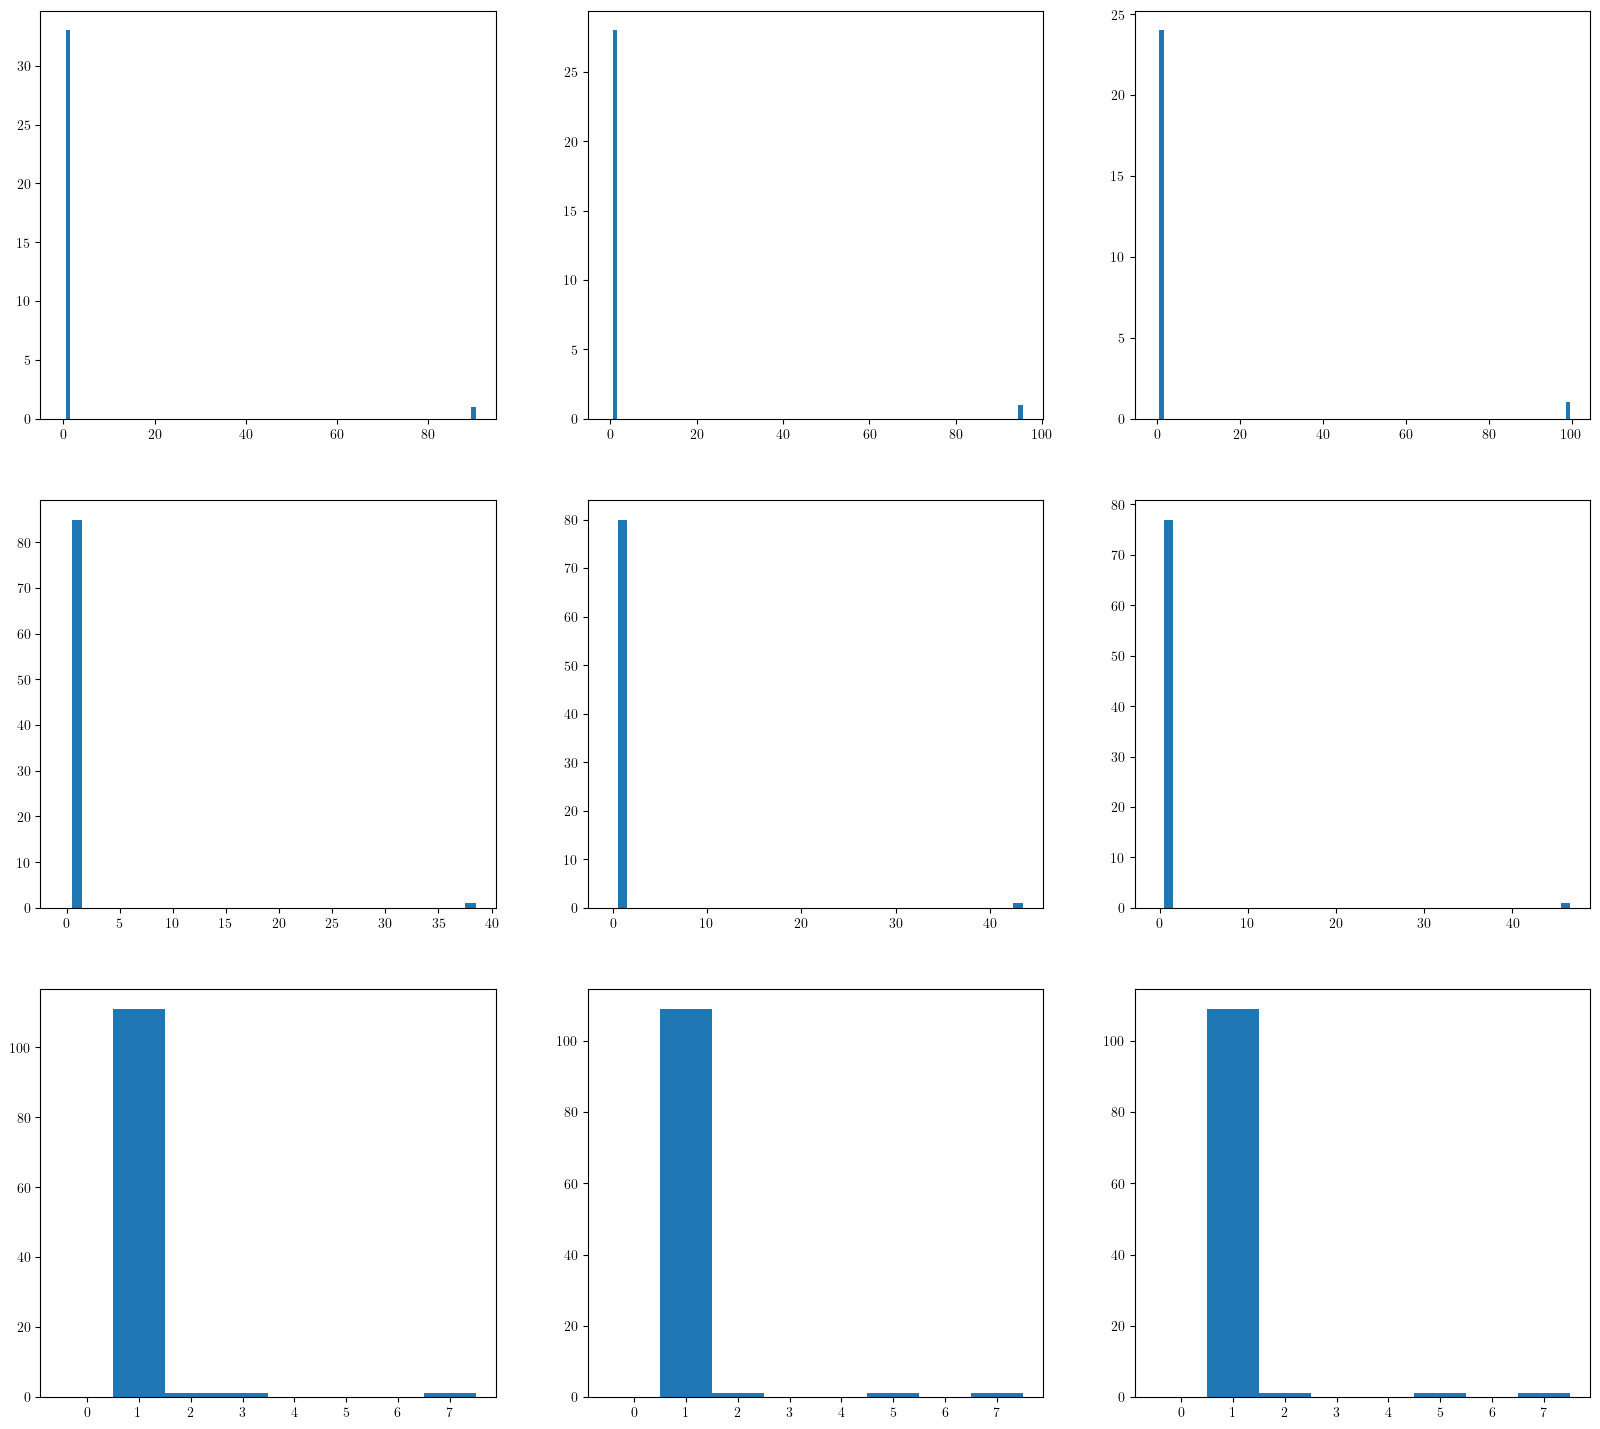

In [28]:
FILES = [
    "5116_spike_mat_or_rand",
]

for idx, fn in enumerate(FILES):
    fig, axs = plt.subplots(3, 3, figsize=(20, 18))
    print(fn)
    print("Lag\t", end="\t")
    for lag in [0, 10, 20]:
        print(lag, end="\t")
    print()
    for r_idx, (r_min, r_max) in enumerate([(0.5, 0.7), (0.7, 0.9), (0.9, 1.0)]):
        print(f"({r_min}, {r_max})", end="\t")
        for lag_idx, lag in enumerate([0, 10, 20]):
            ax = axs[r_idx, lag_idx]
            with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
                data = pickle.load(f)
                data = data["all"]
            cc_counts = data["range_analysis"][(r_min, r_max)]["cc_counts"]
            bins = np.arange(0, np.max(cc_counts) + 1.5) - 0.5
            ax.hist(cc_counts, bins)
            ax.set_title(f"({r_min}, {r_max}), lag={lag}")
            ax.set_xlabel("Size of connected component")
            ax.set_ylabel("Number of connected components")
            cnt = len(cc_counts)
            print(cnt, end="\t")
        print()
    fig.show()
        
        

In [31]:
from ripser import ripser
from persim import plot_diagrams
from matplotlib.ticker import MaxNLocator

import os
os.makedirs("barcodes", exist_ok=True)

# ALL_FILES = [
#     "5116_spike_mat_or_rand",
#     "UCSC_mouse_Pasca_23149",
# ]

for lag in [0, 10, 20]:
    for idx, fn in enumerate(ALL_FILES):
        with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
            data = pickle.load(f)
            data = data["all"]
            dgms = data["ripser"]["dgms"]
        fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
        # fig.suptitle(f"Lag window: {lag} for {fn}", fontsize=20)
        for d in range(3):
            ax = axs[d]
            dgm = 1.0 - data["ripser"]["dgms"][d]
            for i in range(len(dgm)):
                ax.plot([dgm[i][0], dgm[i][1]], [i + 1, i + 1], f'C{d}-', lw=2)
            ax.set_ylabel(f"$H_{d}$", fontsize=20)
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.tick_params(axis='both', which='minor', labelsize=16)
            ax.set_ylim(0.5, max(2.5, len(dgm) + 0.5))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[-1].set_xlabel("correlation coefficient", fontsize=20)
        lines = {
            "UCSC_mouse_Pasca_23149": {10: 0.72, 20: 0.72, 0: 0.765},
            "5116_spike_mat_or_rand": {10: 0.25, 0: 0.20, 20: 0.45},
        }
        if fn in lines and lag in lines[fn]:
            for ax in axs:
                ax.axvline(lines[fn][lag], color='red')
            bs = []
            for d in range(3):
                dgm = 1.0 - data["ripser"]["dgms"][d]
                bs.append(len([b for d, b in dgm if b < lines[fn][lag] < d]))
            bs = f"({bs[0]}, {bs[1]}, {bs[2]})"
            bs = f"Betti numbers: {bs}"
            fig.text(0.5, 0.10, bs, ha='center', fontsize=20)
        fig.tight_layout()
        fig.savefig(f"barcodes/ripser_{fn}_{lag}.png")
        plt.close(fig)

result_32 (119966, 168)
result_33 (60000, 168)


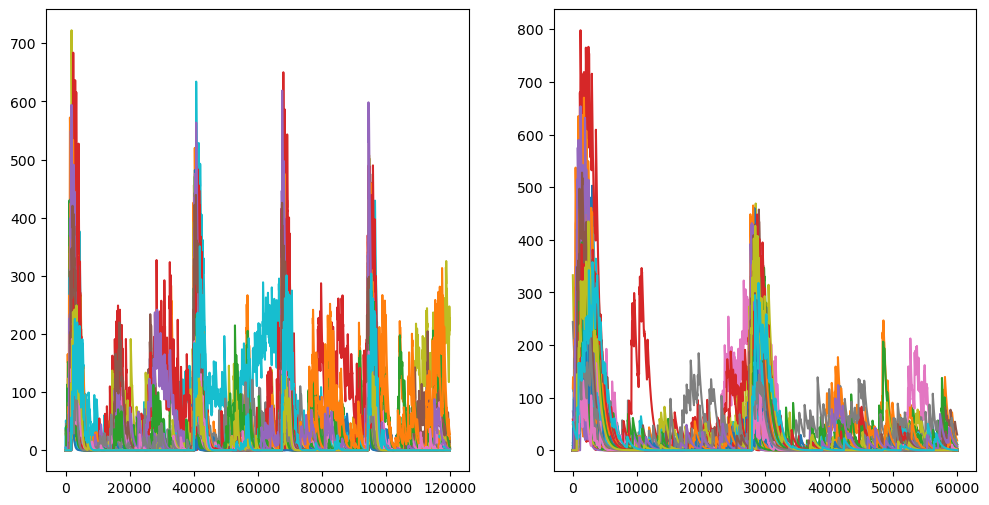

In [17]:
fig, axs = plt.subplots((len(ALL_FILES) + 1) // 2, 2, figsize=(12, len(ALL_FILES) * 3))
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, fn in enumerate(ALL_FILES):
    try:
        data = loadmat(f"{fn}.mat")
        t_spk_mat = data['t_spk_mat']
    except:
        data = h5py.File(f"{fn}.mat")
        t_spk_mat = np.array(data['t_spk_mat']).T
    print(fn, t_spk_mat.shape)
    ax = axs[idx]
    for i in range(100):
        ax.plot(t_spk_mat[:, i], label=f"Neuron {i}")